In [1]:
from utility_functions import *

import os, shutil, sys, time, re, glob, csv, random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import dlib

# Dlib face detector
detector = dlib.get_frontal_face_detector()

# Facial landmarks detector
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
categories = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

images, labels = importDataset('data/CKPlus/', 'ckplus', categories=categories)

image_labels = zip(images, labels)
random.shuffle(image_labels)
print([x[1] for x in image_labels])

# 0 - angry
# 1 - disgust
# 2 - Happy
# 3 - neutral
# 4 - sad
# 5 - surprise

[5, 5, 5, 3, 5, 3, 4, 3, 4, 2, 2, 5, 5, 0, 5, 0, 4, 1, 0, 2, 1, 1, 3, 5, 5, 4, 5, 4, 4, 5, 3, 4, 5, 1, 3, 1, 1, 5, 2, 4, 2, 0, 1, 3, 1, 1, 3, 0, 0, 5, 4, 1, 5, 1, 2, 5, 4, 5, 2, 0, 5, 3, 1, 4, 5, 2, 1, 1, 1, 5, 4, 4, 0, 2, 0, 0, 1, 5, 1, 3, 1, 3, 3, 5, 5, 5, 1, 3, 4, 1, 4, 5, 3, 0, 0, 5, 5, 1, 1, 0, 3, 3, 0, 0, 5, 3, 5, 5, 3, 4, 3, 1, 0, 4, 3, 5, 0, 5, 5, 1, 3, 3, 5, 3, 5, 2, 1, 1, 5, 5, 0, 0, 1, 3, 5, 3, 3, 1, 5, 1, 5, 5, 2, 0, 1, 1, 2, 5, 1, 3, 3, 5, 5, 3, 4, 5, 3, 0, 3, 3, 5, 5, 5, 3, 1, 3, 1, 1, 5, 3, 0, 4, 1, 1, 5, 5, 1, 0, 1, 3, 1, 0, 0, 5, 1, 2, 4, 1, 5, 3, 3, 5, 0, 5, 1, 5, 5, 2, 0, 1, 3, 3, 5, 5, 3, 3, 1, 3, 3, 0, 4, 5, 5, 2, 5, 4, 3, 0, 3, 5, 3, 3, 0, 0, 0, 5, 2, 3, 0, 3, 5, 4, 0, 1, 0, 5, 5, 3, 3, 5, 0, 4, 1, 0, 5, 5, 1, 1, 1, 2, 3, 4, 5, 5, 5, 3, 2, 0, 4, 3, 0, 1, 0, 5, 3, 3, 3, 4, 2, 2, 3, 5, 2, 1, 2, 1, 3, 0, 5, 2, 2, 5, 2, 0, 1, 5, 4, 3, 1, 0, 1, 3, 3, 3, 0, 5, 5, 5, 1, 1, 0, 5, 1, 3, 3, 3, 3, 3, 5]


In [4]:
def get_landmarks(_image):
    """
    takes in an image, detects face in it,
    if face is detected then finds facial landmarks of that face,
    extracts some features as explained in code
    return : list of features corresponding to the detected face,
             if no face is detected, returns "error"
    """
    image = _image.copy()
    detections = detector(image, 1)
    
    # for all detected face instances individually
    for k, d in enumerate(detections):
        
        # get Facial Landmarks with the predictor class
        shape = predictor(image, d)
        
        xlist = []
        ylist = []
        # store X and Y coordinates in two lists
        for i in range(1, 68):
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
                
        xmean = xlist[29]
        ymean = ylist[29]
        
        # get distance between each point and the central point in both axes
        xcentral = [(x - xmean) for x in xlist]
        ycentral = [(y - ymean) for y in ylist]
        
        # point 29 - nose tip
        # point 26 - middle point b/w two eyes
        
        # get angle that nose line makes with vertical, this for correcting tilted faces.
        angle_nose = np.arctan2((ylist[26] - ymean), (xlist[26] - xmean)) * 180 / np.pi
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90
        
        # landmarks_vectorised is the feature vector corresponding to the face
        """
        landmarks_vectorised is of the form
        [p1_x_rel, p1_y_rel, dist(p, centre), angle()]
        """
        landmarks_vectorised = []
        for i in range(0, 67):
            """
            rx - x coordinate of relative position of a point w.r.t central point
            ry - y coordinate of relative position of a point w.r.t central point
            x - absolute x coordinate
            y - absolute y coordinate
            """
            
            rx = xcentral[i]
            ry = ycentral[i]
            x = xlist[i]
            y = ylist[i]
        
            landmarks_vectorised.append(rx)
            landmarks_vectorised.append(ry)

            # calculate length of point i from central point
            dist = np.linalg.norm(np.array([rx, ry]))
            landmarks_vectorised.append(dist)

            # get the angle the vector describes relative to the image, 
            # corrected for the offset that the nosebrigde has when the face is titled
            anglerelative = (np.arctan2((-ry), (-rx)) * 180 / np.pi) - angle_nose
            landmarks_vectorised.append(anglerelative)
        
    if len(detections) < 1: 
        landmarks_vectorised = "error"     
    
    return landmarks_vectorised
        

def make_sets():
    """
    return: creates feature matrix by appending feature vector of 
            each image.
    """
    train_data = []
    test_data = []
    train_label = []
    test_label = []
    
    start_time = time.time()
    
    # take first 80 % of the images for training and rest for testing
    train_image_labels = image_labels[:int(len(image_labels)*0.8)]
    test_image_labels = image_labels[-int(len(image_labels)*0.2):]
    
    for item in train_image_labels:
        
        # open image
        image = cv.imread(item[0]) 
        
        # convert to grayscale
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)
        
        # get feature vector
        landmarks_vectorised = get_landmarks(clahe_image)
        
        if landmarks_vectorised == "error":
            print("no face")
        else:
            train_data.append(landmarks_vectorised)
            train_label.append(item[1])
            
    print('train - ', time.time() - start_time)
    
    for item in test_image_labels:
        image = cv.imread(item[0])
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)
  
        landmarks_vectorised = get_landmarks(clahe_image)
        if landmarks_vectorised == "error":
            pass
        else:
            test_data.append(landmarks_vectorised)
            test_label.append(item[1])
        
    print('test - ', time.time() - start_time)

    return train_data, test_data, train_label, test_label


def plot_confusion_matrix(cm, classes=categories,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
import time

start_time = time.time()
train_data, test_data, training_label, test_label = make_sets()
print('feature extraction done in %f sec' % (time.time() - start_time))

('train - ', 41.57293200492859)
('test - ', 51.627293825149536)
feature extraction done in 51.628480 sec


MLP classifier fit done in 1.018604 sec
MLP clf prediction done in 0.003265 sec
Training accuracy (using MLP) - 83.606557 
Confusion matrix of prediction using MLP classifier
[[ 7  1  0  0  0  0]
 [ 2  8  0  0  0  0]
 [ 0  0  7  1  0  1]
 [ 1  1  1 14  0  0]
 [ 1  0  1  0  2  0]
 [ 0  0  0  0  0 13]]


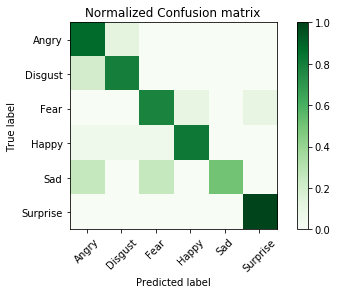

In [6]:
##### Multilayer Perceptron Classifier

from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.metrics import confusion_matrix

train_net = False
model_path_MLP = 'trained_models/MLP_20_30_30_clf_CK_temp.pkl'

if train_net:
    # training
    start_time = time.time()
    nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(20, 30, 30), random_state=1, max_iter=1000)
    nn_clf.fit(train_data, training_label)
    print('MLP classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(nn_clf, model_path_MLP, compress=9)

## prediction
start_time = time.time()
nn_clf = joblib.load(model_path_MLP)
nn_predicted_labels = nn_clf.predict(test_data)
print('MLP clf prediction done in %f sec' % (time.time() - start_time))
print('Training accuracy (using MLP) - %f ' % (np.mean(nn_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, nn_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

training XGB classifier..
XGB classifier fit done in 2.164434 sec
starting XGB prediction..
XGB prediction done in 0.010039 sec
Training accuracy (using XGB) - 72.131148
Confusion matrix of prediction using MLP classifier
[[ 2  4  0  0  2  0]
 [ 1  8  0  1  0  0]
 [ 0  0  6  1  1  1]
 [ 0  2  1 14  0  0]
 [ 1  0  1  0  1  1]
 [ 0  0  0  0  0 13]]


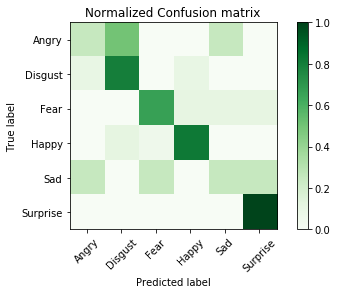

In [7]:
from xgboost import XGBClassifier

train_XGB = False
model_path_XGB = 'trained_models/XGB_temp.pkl'

train_data = np.asarray(train_data)
training_label = np.asarray(training_label)

test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

if train_XGB:
    # training
    # training
    start_time = time.time()
    xgb_clf = XGBClassifier()
    print('training XGB classifier..')
    xgb_clf.fit(train_data, training_label)
    print('XGB classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(xgb_clf, model_path_XGB, compress=9)
    
# prediction
start_time = time.time()
xgb_clf = joblib.load(model_path_XGB)
print('starting XGB prediction..')
xgb_predicted_labels = xgb_clf.predict(test_data)
print('XGB prediction done in %f sec' % (time.time() - start_time))

print('Training accuracy (using XGB) - %f' % (np.mean(xgb_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, xgb_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

training random forest classifier with 100 estimators..
random forest training done in 0.357088 sec
starting prediction using random forest classifier..
Random forest prediction done in 0.063621 sec
Training accuracy (using random forest) - 63.934426
Confusion matrix of prediction using MLP classifier
[[ 3  3  0  0  2  0]
 [ 2  7  0  1  0  0]
 [ 2  1  1  3  0  2]
 [ 0  2  1 14  0  0]
 [ 1  0  1  0  1  1]
 [ 0  0  0  0  0 13]]


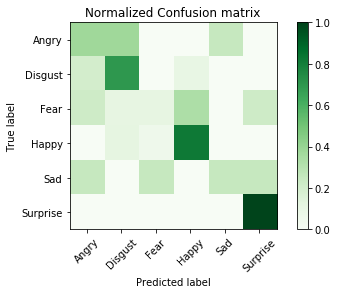

In [46]:
### random forest classifier

from sklearn.ensemble import RandomForestClassifier

train_random_forest = False
model_path_random_forest = 'trained_models/random_forest_100_CK.pkl'

if train_random_forest:
    # training
    start_time = time.time()
    n_estimators = 100
    print('training random forest classifier with %d estimators..' % (n_estimators))
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_features=6)
    rf_clf.fit(train_data, training_label)
    print('random forest training done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(rf_clf, model_path_random_forest, compress=9)
    
# prediction
rf_clf = joblib.load(model_path_random_forest)

start_time = time.time()

print('starting prediction using random forest classifier..')
rf_predicted_labels = rf_clf.predict(test_data)
print('Random forest prediction done in %f sec' % (time.time() - start_time))

print('Training accuracy (using random forest) - %f' % (np.mean(rf_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, rf_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

In [23]:
### external test

def test_external_image(image_path, model_path):
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)

    plt.imshow(clahe_image)
    plt.show()

    features = get_landmarks(clahe_image)

    clf = joblib.load(model_path)
    predicted_labels = clf.predict([features])

    print(categories[predicted_labels[0]])
    print(pd.DataFrame(clf.predict_proba([features]), columns=categories))

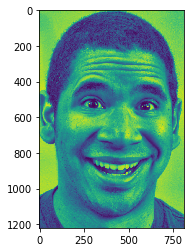

Happy
      Angry   Disgust      Fear     Happy       Sad  Surprise
0  0.016324  0.011661  0.025413  0.903459  0.005505  0.037637


In [51]:
test_external_image('test_images/happily-surprised.jpg', 'trained_models/XGB.pkl')